In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score
import time
from statistics import mean
import math

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id': '1IQfiGz6c3poQStcSRjW-2NVrna3fU29t'})
downloaded.GetContentFile('dataset.pkl')

In [5]:
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [6]:
# Ustawienie ziarna
tf.random.set_seed(1234)

In [7]:
def get_data(part):
    images = dataset[part]['X']
    labels = dataset[part]['y']
    
    return images, labels


def images_preprocessing(images):
    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    
    # Spłaszczanie obrazów do jednego wymiaru (np. z 64x64x3 do 12288)
    #images = tf.reshape(images, [images.shape[0], -1])
    
    # Zmiana typu obrazów z int na float 
    # i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
    
    return images


def labels_preprocessing(labels):
    # Zmiana wymiarowości z [8870] na [8870, 1] 
    # w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])
    
    return labels


def dataset_to_batches(X, y, batch_size=100):
    # Preprocess images
    images = images_preprocessing(X)
    # Preprocess labels
    labels = labels_preprocessing(y)
    
    # Do iterowania zbioru danych i podzielenia na paczki (ang. batch) 
    # można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
    ds = tf.data.Dataset.from_tensor_slices((images, labels)) 
    ds = ds.shuffle(buffer_size=len(images)).batch(batch_size=batch_size)
    
    return ds

In [8]:
# Wczytanie mechanizmu paczkowania dla zbiorów
train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y)

test_X, test_y = get_data("test")
test_ds = dataset_to_batches(test_X, test_y)

val_X, val_y = get_data("validation")
val_ds = dataset_to_batches(val_X, val_y)

In [9]:
class CNNModel(tf.keras.Model):
    def __init__(self, kernel_size, pool_size, pooling):
        super(CNNModel, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=kernel_size, 
                                            strides=(1,1), 
                                            use_bias=True, 
                                            input_shape=(64, 64, 3))
        self.pool1 = pooling(pool_size=pool_size, 
                             strides=(2,2))
        
        self.conv2 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=kernel_size, 
                                            strides=(1,1), 
                                            use_bias=True)
        self.pool2 = pooling(pool_size=pool_size, 
                             strides=(2,2))
        
        self.flat = tf.keras.layers.Flatten()
        
        self.fc1 = tf.keras.layers.Dense(units=384)
        self.fc2 = tf.keras.layers.Dense(units=192)
        self.fc3 = tf.keras.layers.Dense(units=14)
        
        
    def call(self, inputs, training=False):
        conv1_out = tf.keras.activations.relu(self.conv1(inputs))
        pool1_out = self.pool1(conv1_out)
        
        conv2_out = tf.keras.activations.relu(self.conv2(pool1_out))
        pool2_out = self.pool2(conv2_out)
        
        flat_out = self.flat(pool2_out)
        
        fc1_out = tf.keras.activations.relu(self.fc1(flat_out))
        fc2_out = tf.keras.activations.relu(self.fc2(fc1_out))
        fc3_out = tf.keras.activations.softmax(self.fc3(fc2_out))
        
        return fc3_out
    
    
    def fit(self, **kwargs):
        self.loss_list = []
        self.f1_list = []
        self.time_list = []
        
        self.test_loss_list = []
        self.test_f1_list = []
        
        self.val_loss_list = []
        self.val_f1_list = []
        
        ds_train = kwargs.get("ds_train", train_ds)
        ds_test = kwargs.get("ds_test", test_ds)
        ds_val = kwargs.get("ds_val", val_ds)
        
        batch_size = kwargs.get("batch_size", 100)
        learning_rate = kwargs.get("learning_rate", 0.001)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        optimizer = optimizer(learning_rate=learning_rate)
        epochs = kwargs.get("epochs", 25)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        
        for epoch in range(epochs):
            f1 = tfa.metrics.F1Score(num_classes=14, average="macro")
            timer_start = time.time()
            
            for X, y in ds_train:
                with tf.GradientTape() as tape:
                    logits = self.call(X)
                    loss = cost_func(y, logits)
                    
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.loss_list.append(loss)
                self.f1_list.append(f1.result())
            
            #self.f1_list.append(f1.result())
            
            exec_time = time.time() - timer_start
            self.time_list.append(exec_time)
            
            print('TRAINING: Epoch: %d  -  loss: %.3f; F1_score: %.3f; time: %.3fs'%(epoch, 
                                                                                     self.loss_list[-1], 
                                                                                     self.f1_list[-1], 
                                                                                     self.time_list[-1]))
            
            for X, y in ds_test:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.test_loss_list.append(loss)
                self.test_f1_list.append(f1.result())
            
            print('TEST: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                    self.test_loss_list[-1], 
                                                                    self.test_f1_list[-1]))
            
            for X, y in ds_val:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.val_loss_list.append(loss)
                self.val_f1_list.append(f1.result())
            
            print('VALIDATION: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                          self.val_loss_list[-1], 
                                                                          self.val_f1_list[-1]))
            

    def predict(self, X):
        logits = self.call(X)
        pred = tf.argmax(logits, axis=1)
        
        return pred

In [10]:
train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y)

test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)


def cnn_model_experiment(ds_train=train_ds, 
                         ds_test=test_ds, 
                         ds_val=val_ds, 
                         test_X=test_X, 
                         test_y=test_y, 
                         batch_size=100, 
                         learning_rate=0.001, 
                         optimizer=tf.keras.optimizers.Adam, 
                         epochs=25, 
                         cost_func=tf.keras.losses.SparseCategoricalCrossentropy(), 
                         kernel_size=(3,3), 
                         pool_size=(4,4), 
                         pooling=tf.keras.layers.MaxPooling2D):
    model = CNNModel(kernel_size=kernel_size, 
                     pool_size=pool_size, 
                     pooling=pooling)
    
    model.fit(ds_train=ds_train, 
              ds_test=ds_test, 
              ds_val=ds_val, 
              batch_size=batch_size, 
              learning_rate=learning_rate, 
              optimizer=optimizer,
              epochs=epochs, 
              cost_func=cost_func)
    
    el_per_batch = math.ceil(len(train_X) / batch_size)
    loss_list = np.asarray(model.loss_list)
    loss_list = np.mean(loss_list.reshape(-1, el_per_batch), axis=1)

    y_pred = model.predict(test_X)
    f1 = f1_score(test_y, y_pred, average='micro')
    
    return model, f1, loss_list

In [17]:
settings_epochs = [15, 25]
#settings_epochs = [2]
settings_learning_rate = [0.0001, 0.001, 0.01]
#settings_learning_rate = [0.0001]
settings_optimizer = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
#settings_optimizer = [tf.keras.optimizers.Adam]
settings_batch_size = [100, 250, 500]
#settings_batch_size = [100]

res_df = pd.DataFrame(columns=['epochs', 'learning_rate', 'optimizer', 'batch_size', 
                               'f1_score', 'loss', 'time_per_epoch', 'time'])

In [ ]:
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
kernel_size = (5,5)
pool_size = (3,3)
pooling = tf.keras.layers.MaxPooling2D

for epochs in settings_epochs:
    for learning_rate in settings_learning_rate:
        for optimizer in settings_optimizer:
            for batch_size in settings_batch_size:
                tf.random.set_seed(1234)
                
                train_X, train_y = get_data("train")
                train_ds = dataset_to_batches(train_X, train_y, batch_size)
                
                model, f1, loss_list = cnn_model_experiment(ds_train=train_ds, 
                                                            #test_X=test_X, 
                                                            #test_y=test_y, 
                                                            batch_size=batch_size, 
                                                            learning_rate=learning_rate, 
                                                            optimizer=optimizer, 
                                                            epochs=epochs, 
                                                            cost_func=cost_func, 
                                                            kernel_size=kernel_size, 
                                                            pool_size=pool_size, 
                                                            pooling=pooling)
                
                res_df = res_df.append({'epochs': epochs, 
                                        'learning_rate': learning_rate,  
                                        'optimizer': optimizer.__name__, 
                                        'batch_size': batch_size, 
                                        'f1_score': f1, 
                                        'loss': loss_list[-1], 
                                        'time_per_epoch': np.mean(model.time_list), 
                                        'time': np.sum(model.time_list)}, ignore_index=True)
                
                print(f1)

In [19]:
res_df

epochs  learning_rate optimizer  ...       loss  time_per_epoch        time
0      15         0.0001      Adam  ...   1.547071        6.162665   92.439977
1      15         0.0001      Adam  ...   1.864824        5.143116   77.146746
2      15         0.0001      Adam  ...   1.976814        5.066913   76.003697
3      15         0.0001       SGD  ...   2.561635        6.092606   91.389096
4      15         0.0001       SGD  ...   2.587535        5.104061   76.560909
5      15         0.0001       SGD  ...   2.604842        4.857042   72.855623
6      15         0.0010      Adam  ...   0.514168        6.065537   90.983061
7      15         0.0010      Adam  ...   1.652729        5.037106   75.556585
8      15         0.0010      Adam  ...   1.942614        4.798855   71.982818
9      15         0.0010       SGD  ...   2.510562        6.078307   91.174598
10     15         0.0010       SGD  ...   2.538611        5.093876   76.408134
11     15         0.0010       SGD  ...   2.548907        4.851678   72.775174
12     15         0.0100      Adam  ...  13.408292        6.064589   90.968842
13     15         0.0100      Adam  ...  13.409214        5.022317   75.334754
14     15         0.0100      Adam  ...  13.404545        4.723709   70.855629
15     15         0.0100       SGD  ...   2.146863        6.100682   91.510228
16     15         0.0100       SGD  ...   2.336230        5.099213   76.488190
17     15         0.0100       SGD  ...   2.460337        4.852407   72.786098
18     25         0.0001      Adam  ...   0.961480        6.439357  160.983929
19     25         0.0001      Adam  ...   1.568371        5.193318  129.832953
20     25         0.0001      Adam  ...   1.794572        4.898965  122.474125
21     25         0.0001       SGD  ...   2.551956        6.379509  159.487736
22     25         0.0001       SGD  ...   2.571707        5.134143  128.353586
23     25         0.0001       SGD  ...   2.592212        4.869052  121.726305
24     25         0.0010      Adam  ...   0.099192        6.353050  158.826241
25     25         0.0010      Adam  ...   0.717947        5.120685  128.017114
26     25         0.0010      Adam  ...   1.508900        4.834720  120.868008
27     25         0.0010       SGD  ...   2.453200        6.340301  158.507519
28     25         0.0010       SGD  ...   2.526483        5.142499  128.562473
29     25         0.0010       SGD  ...   2.541068        4.872483  121.812085
30     25         0.0100      Adam  ...  13.406738        6.362371  159.059277
31     25         0.0100      Adam  ...  13.409212        5.082901  127.072534
32     25         0.0100      Adam  ...  13.406433        4.743815  118.595384
33     25         0.0100       SGD  ...   1.907337        6.352056  158.801402
34     25         0.0100       SGD  ...   2.221669        5.150222  128.755555
35     25         0.0100       SGD  ...   2.354326        4.889272  122.231810

[36 rows x 8 columns]

In [20]:
settings_kernel_size = [(3,3), (5,5), (7,7)]
#settings_kernel_size = [(3,3)]
settings_pool_size = [(2,2), (3,3), (4,4)]
#settings_pool_size = [(2,2)]
settings_pooling = [tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D]
#settings_pooling = [tf.keras.layers.MaxPooling2D]

res_df = pd.DataFrame(columns=['kernel_size', 'pool_size', 'pooling', 
                               'f1_score', 'loss', 'time_per_epoch', 'time'])

In [ ]:
batch_size = 100
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam
epochs = 25
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()


for kernel_size in settings_kernel_size:
    for pool_size in settings_pool_size:
        for pooling in settings_pooling:
            tf.random.set_seed(1234)
            
            train_X, train_y = get_data("train")
            train_ds = dataset_to_batches(train_X, train_y, batch_size)

            model, f1, loss_list = cnn_model_experiment(ds_train=train_ds, 
                                                        #test_X=test_X, 
                                                        #test_y=test_y, 
                                                        batch_size=batch_size, 
                                                        learning_rate=learning_rate, 
                                                        optimizer=optimizer, 
                                                        epochs=epochs, 
                                                        cost_func=cost_func, 
                                                        kernel_size=kernel_size, 
                                                        pool_size=pool_size, 
                                                        pooling=pooling)
            
            res_df = res_df.append({'kernel_size': kernel_size, 
                                    'pool_size': pool_size,  
                                    'pooling': pooling.__name__, 
                                    'f1_score': f1, 
                                    'loss': loss_list[-1], 
                                    'time_per_epoch': np.mean(model.time_list), 
                                    'time': np.sum(model.time_list)}, ignore_index=True)
            
            print(f1)

In [23]:
res_df

kernel_size pool_size  ... time_per_epoch        time
0       (3, 3)    (2, 2)  ...       6.908147  172.703667
1       (3, 3)    (2, 2)  ...       6.585371  164.634275
2       (3, 3)    (3, 3)  ...       5.505854  137.646348
3       (3, 3)    (3, 3)  ...       6.218578  155.464444
4       (3, 3)    (4, 4)  ...       5.749341  143.733531
5       (3, 3)    (4, 4)  ...       6.670876  166.771904
6       (5, 5)    (2, 2)  ...       7.568970  189.224239
7       (5, 5)    (2, 2)  ...       7.305525  182.638129
8       (5, 5)    (3, 3)  ...       6.426897  160.672426
9       (5, 5)    (3, 3)  ...       7.109825  177.745636
10      (5, 5)    (4, 4)  ...       6.625368  165.634193
11      (5, 5)    (4, 4)  ...       7.475635  186.890887
12      (7, 7)    (2, 2)  ...       7.791808  194.795201
13      (7, 7)    (2, 2)  ...       7.559499  188.987482
14      (7, 7)    (3, 3)  ...       6.786953  169.673831
15      (7, 7)    (3, 3)  ...       7.400569  185.014237
16      (7, 7)    (4, 4)  ...       7.019193  175.479816
17      (7, 7)    (4, 4)  ...       7.790427  194.760677

[18 rows x 7 columns]

In [36]:
res_df.to_csv('results.csv')

In [ ]:
# Zbiór szkoleniowy
tf.random.set_seed(1234)

# Zbiór testowy
#ds_test = test_ds

# Zbiór walidacyjny
#ds_val = val_ds

# Wielkość paczki: 100
batch_size = 100

train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y, batch_size)

test_X, test_y = get_data("test")
test_ds = dataset_to_batches(test_X, test_y, batch_size)

val_X, val_y = get_data("validation")
val_ds = dataset_to_batches(val_X, val_y, batch_size)

# Współczynnik uczenia: 0.001
learning_rate = 0.0001

# Optymalizator: Adam
optimizer = tf.keras.optimizers.Adam

# Liczba epok: 25
epochs = 25

# Funkcja kosztu: tf.keras.losses.SparseCategoricalCrossentropy
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

kernel_size = (5,5)
pool_size = (4,4)
pooling = tf.keras.layers.MaxPooling2D

model, f1, loss_list = cnn_model_experiment(ds_train=train_ds, 
                                            ds_test=test_ds, 
                                            ds_val=val_ds,
                                            #test_X=test_X, 
                                            #test_y=test_y, 
                                            batch_size=batch_size, 
                                            learning_rate=learning_rate, 
                                            optimizer=optimizer, 
                                            epochs=epochs, 
                                            cost_func=cost_func, 
                                            kernel_size=kernel_size, 
                                            pool_size=pool_size, 
                                            pooling=pooling)

In [25]:
f1

0.3988536749831423

In [26]:
def plot_results(list_to_plot, title, xlab, ylab):
    arr = np.asarray(list_to_plot)
    arr = np.mean(arr.reshape(-1, el_per_batch), axis=1)
    
    plt.plot(arr)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

Train

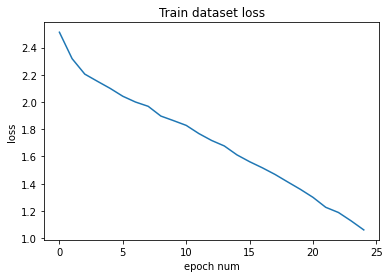

In [27]:
el_per_batch = math.ceil(len(train_X) / batch_size)

plot_results(list_to_plot=model.loss_list, 
             title='Train dataset loss', 
             xlab='epoch num', 
             ylab='loss')

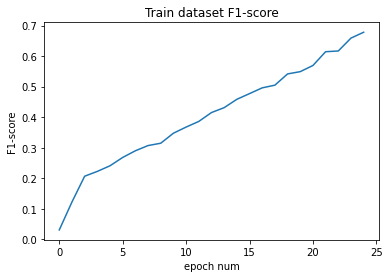

In [28]:
plot_results(list_to_plot=model.f1_list, 
             title='Train dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

Test

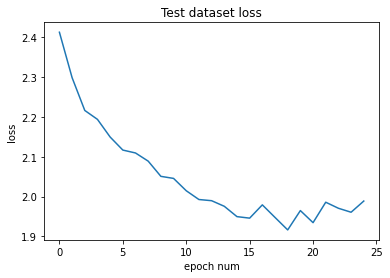

In [29]:
el_per_batch = math.ceil(len(test_X) / batch_size)

plot_results(list_to_plot=model.test_loss_list, 
             title='Test dataset loss', 
             xlab='epoch num', 
             ylab='loss')

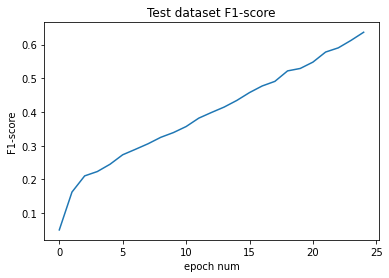

In [30]:
plot_results(list_to_plot=model.test_f1_list, 
             title='Test dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

Validation

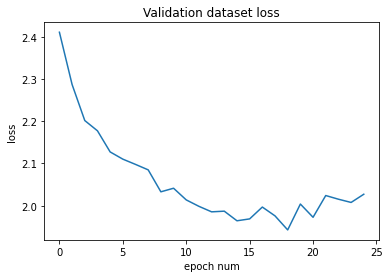

In [31]:
el_per_batch = math.ceil(len(val_X) / batch_size)

plot_results(list_to_plot=model.val_loss_list, 
             title='Validation dataset loss', 
             xlab='epoch num', 
             ylab='loss')

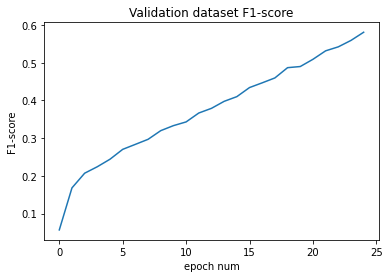

In [32]:
plot_results(list_to_plot=model.val_f1_list, 
             title='Validation dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

Confusion matrix

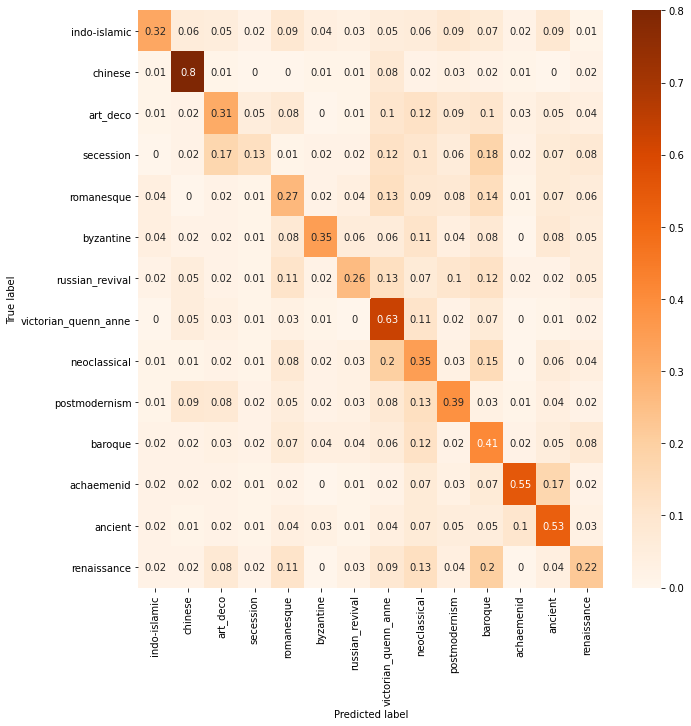

In [33]:
classes = list(dataset['labels_mapping'].keys())

test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)

y_pred = model.predict(test_X)

con_mat = tf.math.confusion_matrix(labels=test_y, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Oranges)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
def display_image_with_pred(image, pred_class):
    plt.imshow(image)
    title = 'Pred class: ' + str(pred_class)
    plt.title(title)
    plt.show()

===== REAL CLASS: indo-islamic =====


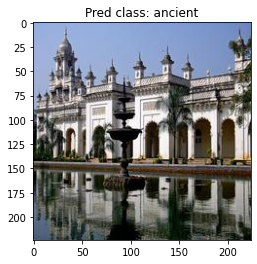

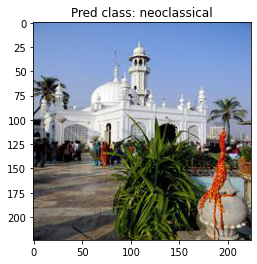

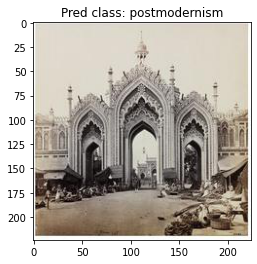

===== REAL CLASS: chinese =====


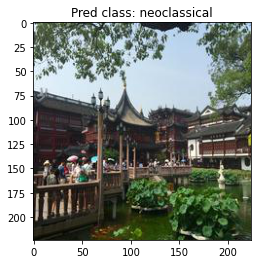

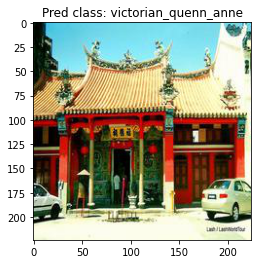

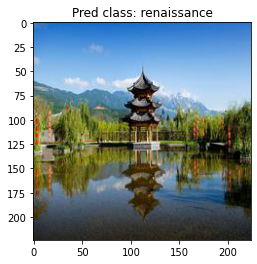

===== REAL CLASS: art_deco =====


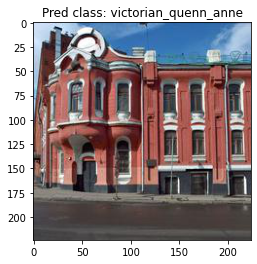

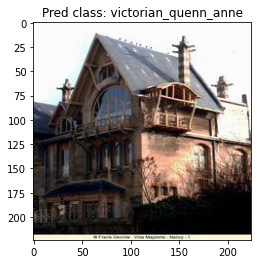

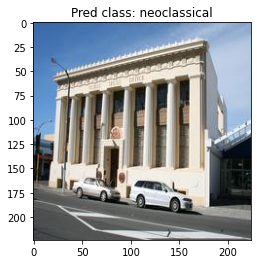

===== REAL CLASS: secession =====


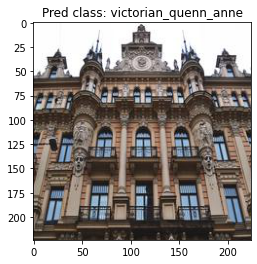

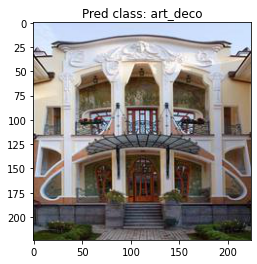

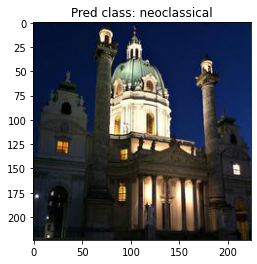

===== REAL CLASS: romanesque =====


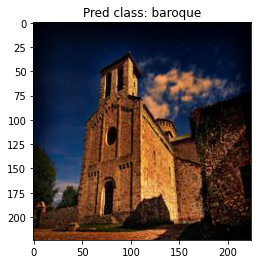

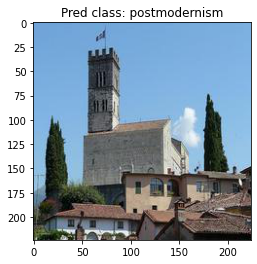

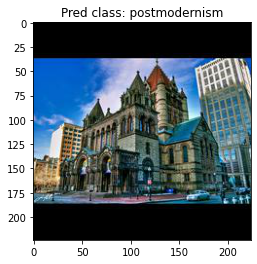

===== REAL CLASS: byzantine =====


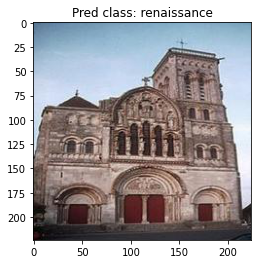

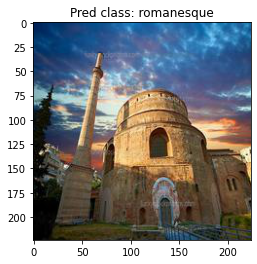

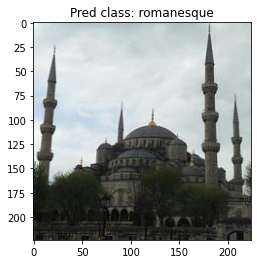

===== REAL CLASS: russian_revival =====


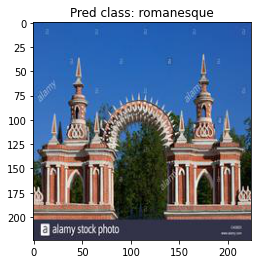

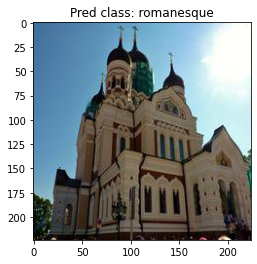

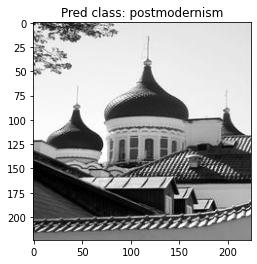

===== REAL CLASS: victorian_quenn_anne =====


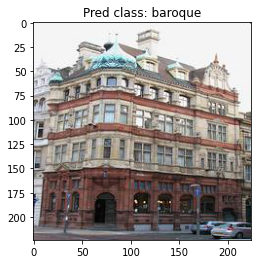

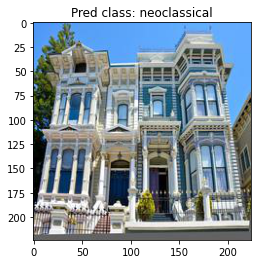

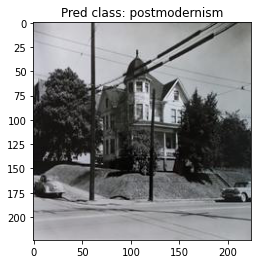

===== REAL CLASS: neoclassical =====


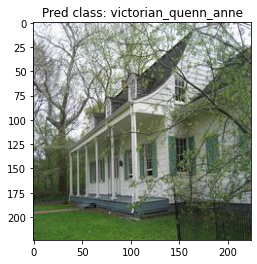

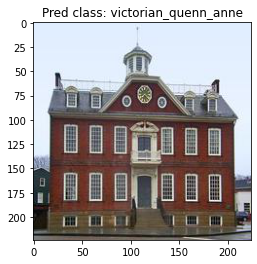

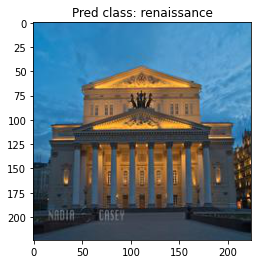

===== REAL CLASS: postmodernism =====


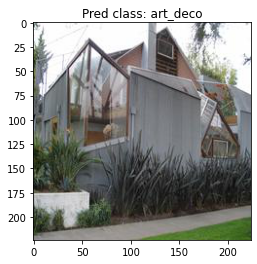

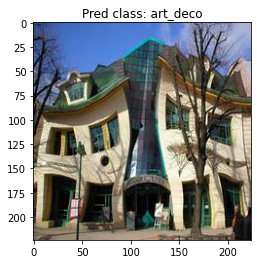

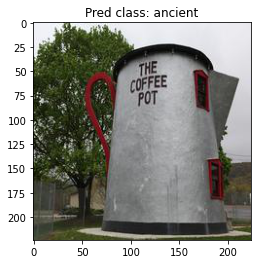

===== REAL CLASS: baroque =====


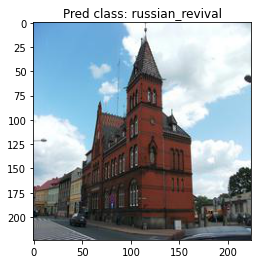

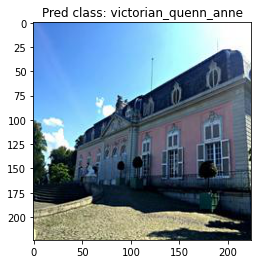

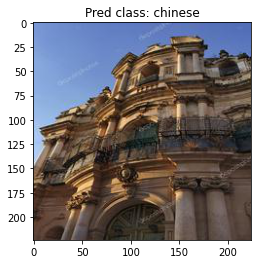

===== REAL CLASS: achaemenid =====


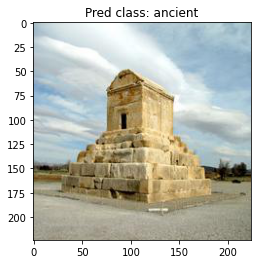

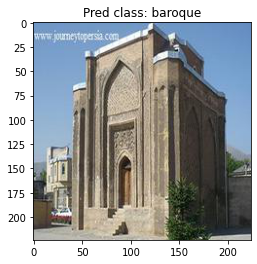

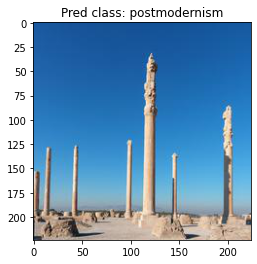

===== REAL CLASS: ancient =====


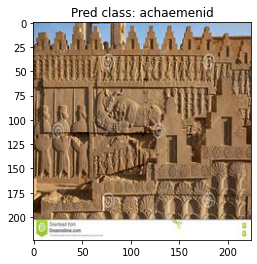

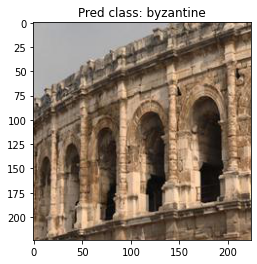

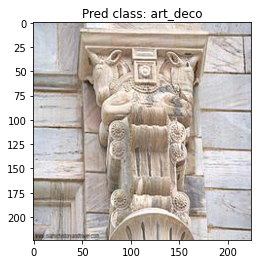

===== REAL CLASS: renaissance =====


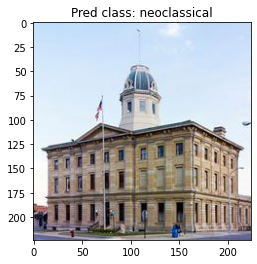

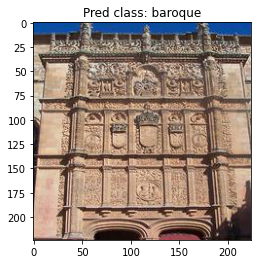

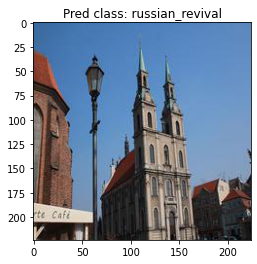

In [35]:
NUM_OF_INCORRRECT_PER_CLASS = 3

test_X, test_y = get_data("test")
test_y = labels_preprocessing(test_y)

for class_num in range(len(classes)):
    print('===== REAL CLASS:', classes[class_num], '=====')
    
    cnt = NUM_OF_INCORRRECT_PER_CLASS
    for image, label, pred in zip(test_X, test_y, y_pred):
        if label.numpy()[0] == class_num:
            if pred != label and cnt > 0:
                display_image_with_pred(image, classes[pred])
                cnt -= 1

### Podsumowanie
Zaimplementowano zdefiniowaną w treści zadania architekturę sieci konwolucyjnej.


Kolejno zbadano wpływ następujących hiperparametrów modelu, na efekty uczenia:
- Liczba epok uczenia
    - badano następujące ilości epok: {15, 25}
- Metoda optymalizacji modelu wraz z przebadaniem różnych wartości współczynnika uczenia
    - badano następujące metody optymalizacji: {Adam, SGD}
    - w zestawieniu z wartościami współczynnika uczenia: {0.0001, 0.001, 0.01}
- Różne liczności paczek (mini batch)
    - badano ilości paczek: {100, 250, 500}
    
Najleprze wyniki (F1 = 0.383007) otrzymano dla usatwień:
- ilość epok = 25
- metoda optymalizacji = Adam
- wartość współczynnika uczenia = 0.0001
- wielkość paczek = 100


Korzytsając z informacji zdobytych z poprzednich eksperymentów, przetestowano następujące parametry sieci konwolucyjnej:
- Rozmiar filtra
    - badano następujące wielkości filtra: {(3,3), (5,5), (7,7)}
- Metoda pooling oraz jej rozmiar
    - badano następujące metody pooling: {MaxPooling2D, AveragePooling2D}
    - w zestawieniu z rozmiarami okna: {(2,2), (3,3), (4,4)}
    
Najleprze wyniki (F1 = 0.404922) otrzymano dla usatwień:
- rozmiar filtra = (5,5)
- metoda pooling = MaxPooling2D
- rozmiar okna pool = (4,4)


Po dokonaniu ewaluacji znalezionej najlepszej konfiguracji hiperparametrów na zbiorze testowym, przedstawiono wizualizacje otrzymanych rezultatów:
- zestawienie wartości metryki F1 w zależności od epoki (dla zbioru treningowego, walidacyjnego i testowego)
- wykresy krzywej funkcji kosztu w zależności od epoki (dla zbioru treningowego, walidacyjnego i testowego)
- krzywą funkcji kosztu w zależności od numeru epoki
- macierz pomyłek
- zwizualizowano kilka przykładów na klasę, dla których model podejmowal złą decyzję

### Wnioski
- Zaimplementowana architektura sieci konwoluncyjnej znacząco poprawiła rezultaty w odniesieniu do modeli mlp z poprzednich zadań
- Za kożdym razem lepsze wyniki uzyskano ustawiając mniejszą wielkość paczek, jednak przekłada się to na dłuższy czas uczenia
- Zwiększenie epok uczenia polepsza wyniki
- Optymalizator Adam działa lepiej w zestawieniem z niższymi ustawieniami wartości współczynnika uczenia
- Optymalizator SGD działa lepiej w zestawieniem z wyższymi ustawieniami wartości współczynnika uczenia
- Metoda pooling MaxPooling2D oraz rozmiar okna pool (4,4) za kazdym razem przekładały się na lepsze rezultaty
- Rozmiar filtra nie wpływa jednoznacznie na wyniki